# Forecasting 2022 purchases with data from 2021 


### Exploratory analysis

In [17]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
import itertools  
from prophet import Prophet
import plotly

Convert raw feather file to csv  

In [212]:
#orders = pd.read_feather("/ORDER_ITEMS_11-11-22.feather") 
#orders.to_csv('order_items.csv',index=False)

Loading csv to notebook

In [31]:
order = pd.read_csv('order_items.csv')
order.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205512 entries, 0 to 205511
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   order_id                 205512 non-null  int64  
 1   id                       205512 non-null  int64  
 2   display_order_id         205512 non-null  object 
 3   created_date             205508 non-null  object 
 4   product_denomination     205508 non-null  float64
 5   product_currency         205508 non-null  object 
 6   product_sku              205508 non-null  object 
 7   sender_name              205512 non-null  object 
 8   recipient_name           205512 non-null  object 
 9   delivery_type            205508 non-null  float64
 10  recipient_email          173908 non-null  object 
 11  recipient_address_line1  687 non-null     object 
 12  recipient_phone          30889 non-null   object 
dtypes: float64(2), int64(2), object(9)
memory usage: 20.4+ MB


In [23]:
order.shape

(205512, 13)

Get summary stats of the product denomination column

In [6]:
order['product_denomination'].describe()

count    205508.000000
mean       6734.279035
std        9564.351433
min        1499.000000
25%        2500.000000
50%        5000.000000
75%        7500.000000
max      200000.000000
Name: product_denomination, dtype: float64

In [32]:
order[order['created_date'].isna()]
order = order.dropna(subset = 'created_date')
order.shape 
# We see that the last four rows of created_date are empty, and we will remove them

(205508, 13)

In [10]:
#examine another attribute: product_sku
unique = set(order['product_sku'])
print(len(unique))


131


By studying the unique values of product_sku, we see that names are composed of: 

- the first three or more character denoting a company like uber, ubereats, doordash 
- the following three characters denoting whether it is LGC or B2C (B2C app)
- the next set of three denoting the currency such as USD, CAD  
- and other digits which might represent value amount or other details 

Given these observations drawn, we will perform some operation on the product_sku string to reveal only the company name in our analysis. 

### Data cleaning and preprocessing

In [34]:
#renaming dataset for post-exploratory analysis work
df = order 

#filter the table to look at USD only, switch to CAD, EUR, GBP, AUD and re-run the rest to produce forecast
df = df.loc[df['product_currency']=='USD']
#dropping rows where created_date is null 
df = df.dropna(subset='created_date')

#take average of denomination per each created date
df3 = df.groupby(['created_date'])['product_denomination'].mean()

### Preliminary analysis

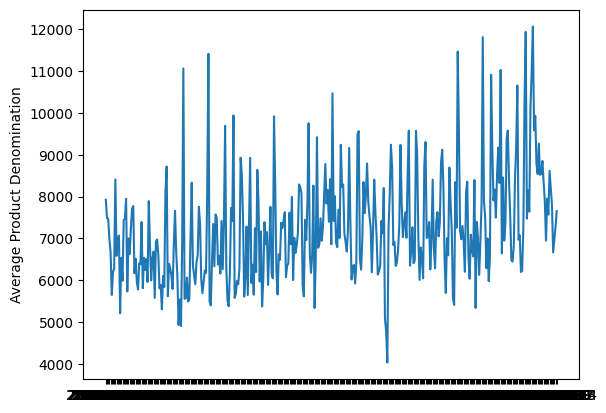

In [41]:
plt.plot(df3)
plt.ylabel('Average Product Denomination')
plt.show() 

Below is run to decompose series into original, trend, seasonality, and noise

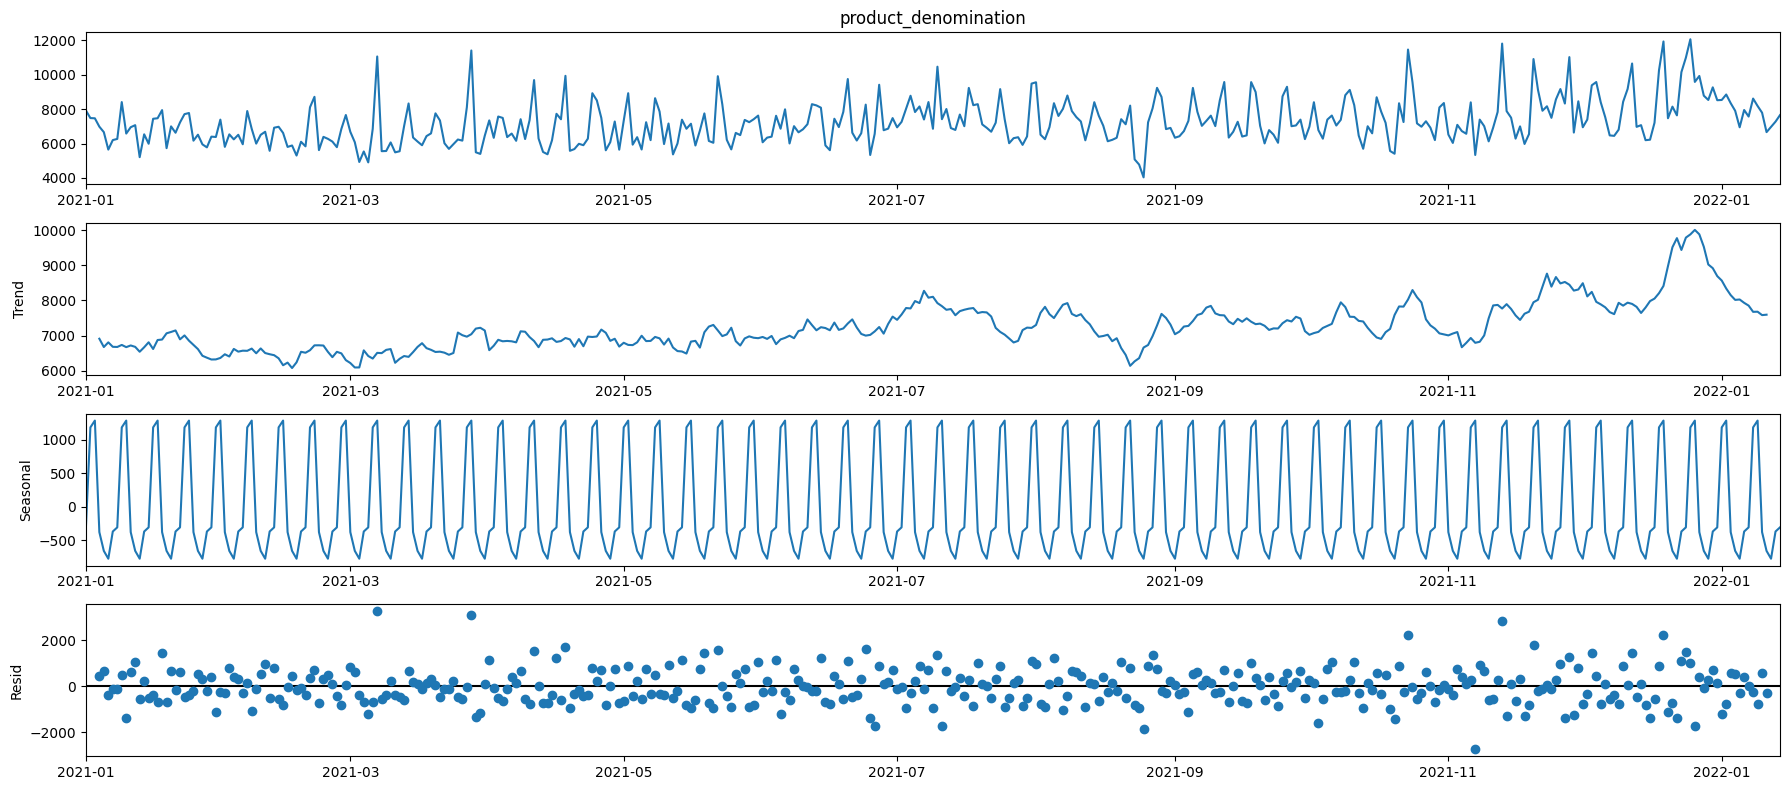

In [43]:
datetime_series = pd.to_datetime(df['created_date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
df2 = df.set_index(datetime_index)
df2.drop('created_date',axis=1,inplace=True)

y = df2['product_denomination'].resample('D').mean()

from pylab import rcParams
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
rcParams['figure.figsize'] = 18, 8
fig = decomposition.plot()
plt.show()

The chart above shows that the time series indeed have a strong seasonality and a residual plot that is highly random. However, we can see that there is an obvious upward trend that started from November of 2021 and it lasted for two months.

Create a subset of the data to serve as input for the Prophet function input

In [279]:
df3.to_csv('out.csv',index=True)

file = 'out.csv'
data = pd.read_csv(file) 
data["created_date"]=data["created_date"].astype('datetime64[ns]')
data['product_denomination'] = data['product_denomination'] .astype(int)
data = data.rename(columns={'created_date': 'ds','product_denomination': 'y'})

### Forecast Model Building

In [ ]:
my_model = Prophet(interval_width=0.95)
my_model.fit(data)

10:30:39 - cmdstanpy - INFO - Chain [1] start processing
10:30:39 - cmdstanpy - INFO - Chain [1] done processing


In [295]:
future_dates = my_model.make_future_dataframe(periods=351, freq='D')  #Use period=12 freq='MS' for forecast by month

In [296]:
forecast = my_model.predict(future_dates)
#forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

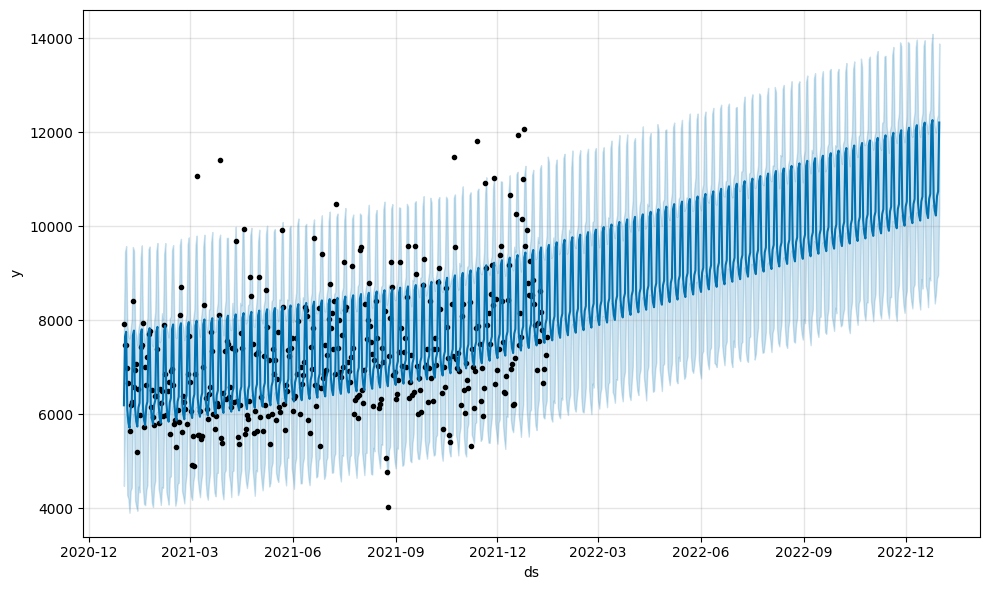

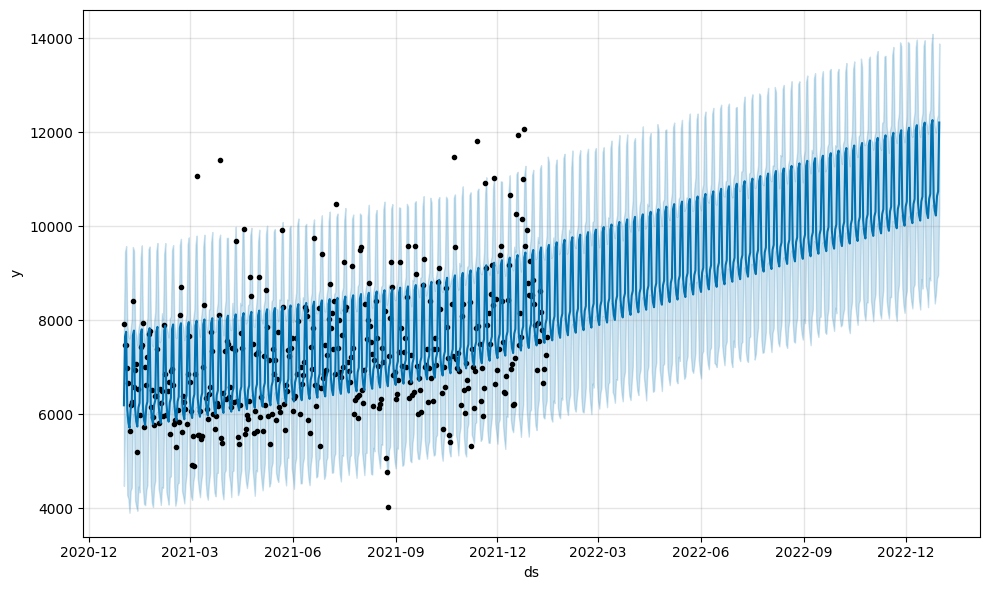

In [297]:
my_model.plot(forecast, uncertainty=True)

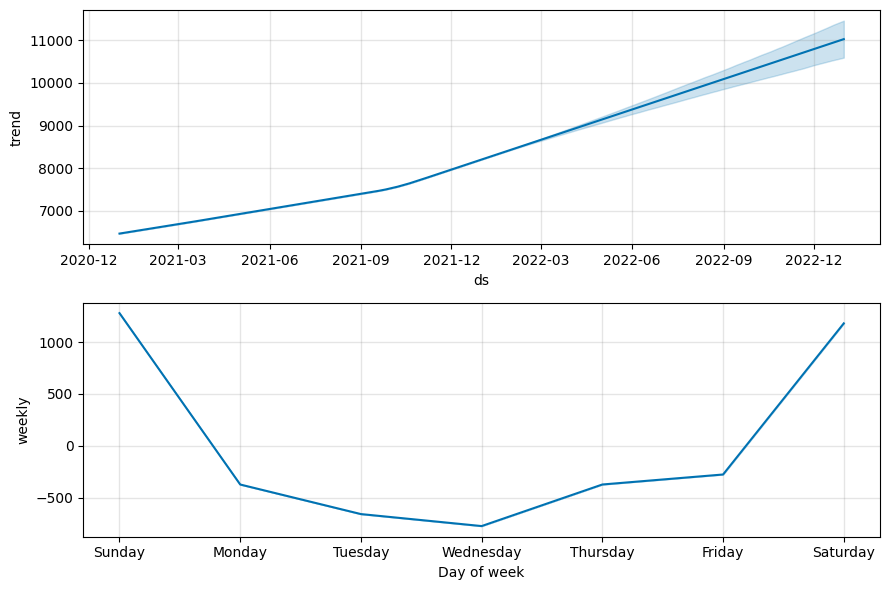

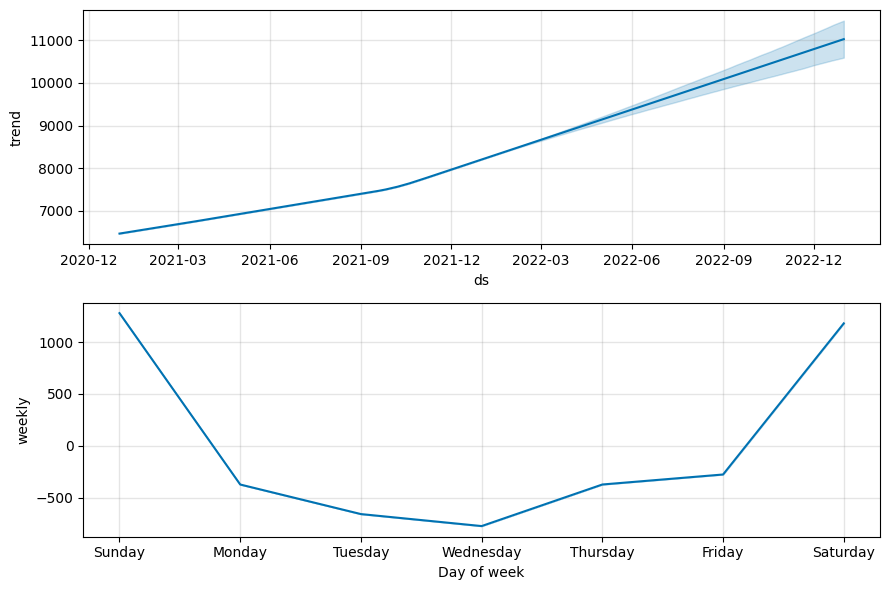

In [298]:
my_model.plot_components(forecast)

Identify anytime in the series where abrupt changes has occured

In [299]:
my_model.changepoints

12    2021-01-13
24    2021-01-25
36    2021-02-06
48    2021-02-18
60    2021-03-02
72    2021-03-14
85    2021-03-27
97    2021-04-08
109   2021-04-20
121   2021-05-02
133   2021-05-14
145   2021-05-26
157   2021-06-07
169   2021-06-19
181   2021-07-01
193   2021-07-13
205   2021-07-25
217   2021-08-06
230   2021-08-19
242   2021-08-31
254   2021-09-12
266   2021-09-24
278   2021-10-06
290   2021-10-18
302   2021-10-30
Name: ds, dtype: datetime64[ns]

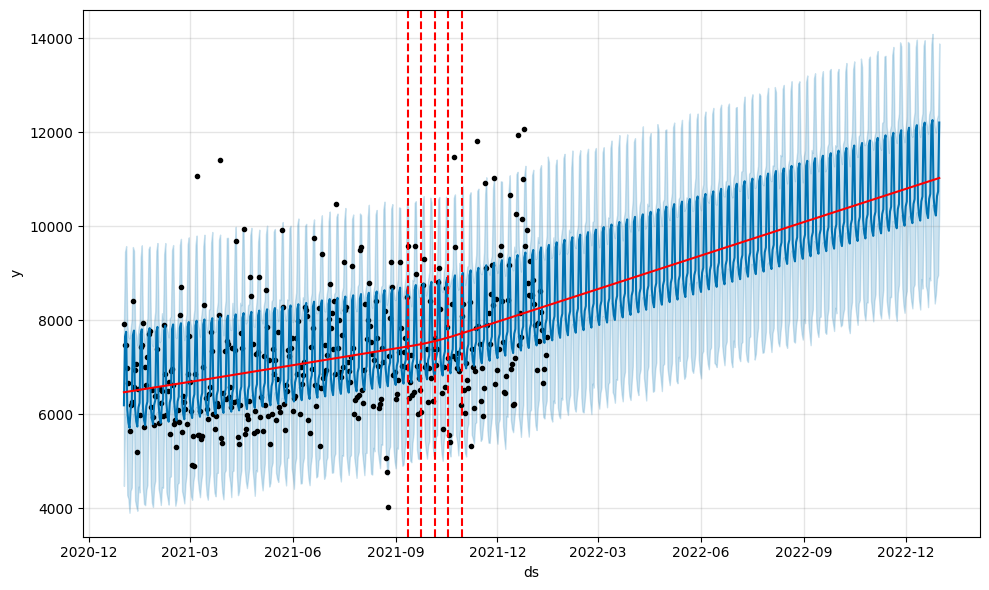

In [300]:
from prophet.plot import add_changepoints_to_plot
fig = my_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), my_model, forecast)

10:58:55 - cmdstanpy - INFO - Chain [1] start processing
10:58:56 - cmdstanpy - INFO - Chain [1] done processing


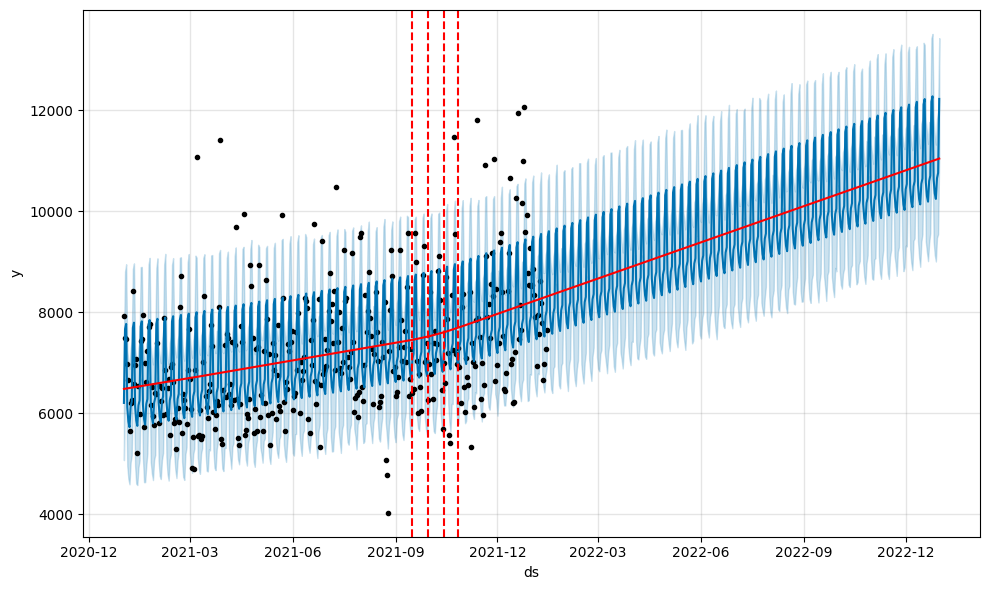

In [301]:
pro_change= Prophet(changepoint_range=0.9)
forecast = pro_change.fit(data).predict(future_dates)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

After adding change points and adjusting for trend, we arrive at the final forecast.

10:59:00 - cmdstanpy - INFO - Chain [1] start processing
10:59:00 - cmdstanpy - INFO - Chain [1] done processing


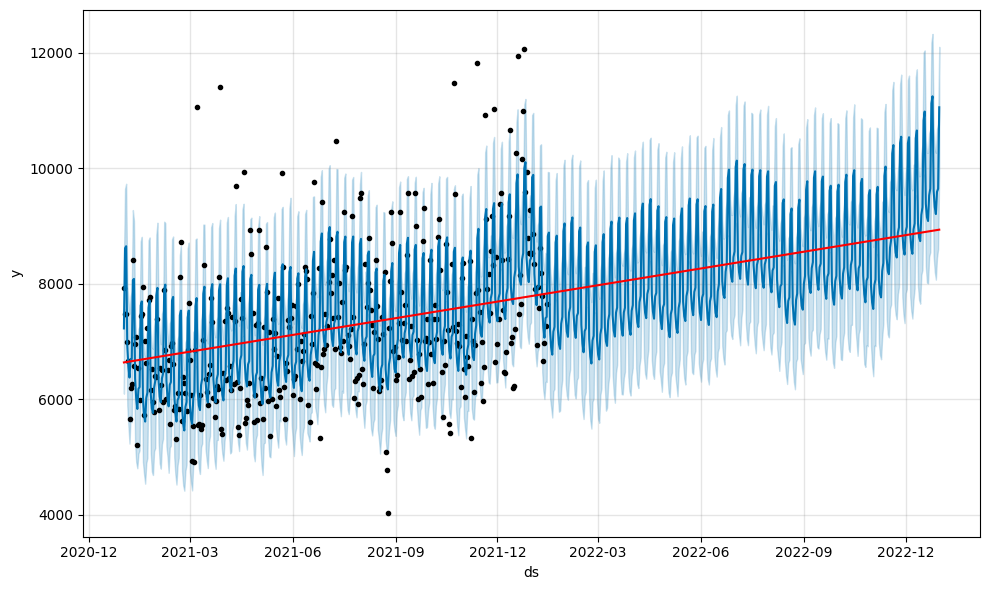

In [302]:
pro_change= Prophet(n_changepoints=20, yearly_seasonality=True, changepoint_prior_scale=0.08)
forecast = pro_change.fit(data).predict(future_dates)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

Summarizing forecasted average denomination in USD

In [303]:
extract ={'ds':forecast['ds'],'y':forecast['yhat'] }
output = pd.DataFrame(extract)
output = output.rename(columns={'ds': 'date','y': 'predicted_average_denomination'})

start_date = '2022-01-14'
end_date = '2023-01-01'
# select rows between two dates
mask = (output['date'] > start_date) & (output['date'] <= end_date)
final_output = output.loc[mask]
final_output

,date,predicted_average_denomination
379,2022-01-15,8822.805776
380,2022-01-16,8882.673766
381,2022-01-17,7200.871898
382,2022-01-18,6895.396228
383,2022-01-19,6768.522764
...,...,...
725,2022-12-27,9324.295970
726,2022-12-28,9203.477835
727,2022-12-29,9589.082232
728,2022-12-30,9641.592128


### End 

In [ ]:
#Appendix
# Prior to using Prophet, the SARIMAX function was used in attempt to create the forecast model. However, the result from this model is not favorable due to the following reasons. 
#1. SARIMA is a little more robust compared to ARIMA while dealing with seasonality. However, it is not robust enough to handle holiday effects and other shocks. 
#2. SARIMA was ran on average denomination per day, and average is vulnerable to extreme values  
#3. Increasing the sample size, i.e. having more than one year’s data, should boost the accuracy of the model 

# See below for the code used in the attempt.

# import statsmodels.api as sm

# p = d = q = range(0, 2)
# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
# print('Examples of parameter combinations for Seasonal ARIMA...')
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(y,
#                                             order=param,
#                                             seasonal_order=param_seasonal,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False,
#                                             )
#             results = mod.fit(disp=0)
#             print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
#         except:
#             continue

# Could not yield any SARIMAX model with AIC < 6000, which raised the red flag of this approach 

# mod = sm.tsa.statespace.SARIMAX(y,
#                                 order=(1, 1, 1),
#                                 seasonal_order=(0, 1, 1, 12),
#                                 enforce_stationarity=False,
#                                 enforce_invertibility=False)
# results = mod.fit()
# print(results.summary().tables[1])

# Here we rrived at unconstrainted problem

# results.plot_diagnostics(figsize=(16, 8))
# plt.show()

# pred_uc = results.get_forecast(steps=100)
# pred_ci = pred_uc.conf_int()
# ax = y.plot(label='observed', figsize=(14, 7))
# pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
# ax.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
# plt.legend()
# plt.show()
#
# In short, this approach was not successful in generating a prediction model.